In [1]:
%matplotlib widget

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import vectorbt as vbt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot

In [3]:
data = yf.download('GC=F SI=F', start = '2016-01-01')
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Price             Close                    High                     Low  \
Ticker             GC=F       SI=F         GC=F       SI=F         GC=F   
Date                                                                      
2016-01-04  1075.099976  13.817000  1082.500000  14.100000  1063.199951   
2016-01-05  1078.400024  13.949000  1081.500000  13.949000  1075.300049   
2016-01-06  1091.900024  13.957000  1093.699951  14.065000  1081.599976   
2016-01-07  1107.699951  14.335000  1109.400024  14.340000  1091.599976   
2016-01-08  1097.800049  13.908000  1111.099976  14.060000  1093.000000   
...                 ...        ...          ...        ...          ...   
2025-05-29  3317.100098  33.283001  3328.800049  33.439999  3242.399902   
2025-05-30  3288.899902  32.891998  3318.000000  32.974998  3270.899902   
2025-06-02  3370.600098  34.563000  3380.800049  34.790001  3296.899902   
2025-06-03  3350.199951  34.502998  3390.000000  34.502998  3331.300049   
2025-06-04  3399.100098  34.615002  3380.000000  34.825001  3344.000000   

Price                         Open             Volume         
Ticker           SI=F         GC=F       SI=F    GC=F   SI=F  
Date                                                          
2016-01-04  13.817000  1063.400024  14.100000     143     27  
2016-01-05  13.949000  1075.599976  13.949000      82      4  
2016-01-06  13.957000  1081.599976  14.000000      52    105  
2016-01-07  14.330000  1091.599976  14.335000     122    286  
2016-01-08  13.908000  1111.099976  14.060000      98      6  
...               ...          ...        ...     ...    ...  
2025-05-29  32.660000  3283.699951  32.910000   24370    686  
2025-05-30  32.891998  3315.100098  32.974998    2213    380  
2025-06-02  33.450001  3296.899902  33.450001     976    188  
2025-06-03  34.314999  3385.100098  34.314999     976    188  
2025-06-04  34.355000  3377.800049  34.680000  150254  41736  

[2367 rows x 10 columns]

In [4]:
data['Close']

Ticker,GC=F,SI=F
Date,,
2016-01-04,1075.099976,13.817000
2016-01-05,1078.400024,13.949000
2016-01-06,1091.900024,13.957000
2016-01-07,1107.699951,14.335000
2016-01-08,1097.800049,13.908000
...,...,...
2025-05-29,3317.100098,33.283001
2025-05-30,3288.899902,32.891998
2025-06-02,3370.600098,34.563000


In [5]:
ratios = data['Close', 'GC=F'] / data['Close', 'SI=F']
ratio = pd.DataFrame(ratios)
ratio.columns = ['Ratio']
window = 50
ratio['rolling_mean'] = ratio['Ratio'].rolling(window=window).mean()
ratio['rolling_std'] = ratio['Ratio'].rolling(window=window).std()
ratio['rolling_zscore'] = (ratio['Ratio'] - ratio['rolling_mean'] ) / ratio['rolling_std']

In [6]:
entries = ratio['rolling_zscore'] < -3
exits = ratio['Ratio'] > ratio['rolling_mean']
short_entries = ratio['rolling_zscore'] > 3
short_exits = ratio['Ratio'] < ratio['rolling_mean']

# Add all signals to the dataframe for backtrader
ratio['long_entry'] = entries.astype(int)  # Convert boolean to int
ratio['long_exit'] = exits.astype(int)
ratio['short_entry'] = short_entries.astype(int) 
ratio['short_exit'] = short_exits.astype(int)
ratio = ratio.dropna()
# Ensure we have clean data without NaN/Inf
ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()

# DEBUG: Print signal summary
print("=== SIGNAL DEBUG INFO ===")
print(f"Total data points: {len(ratio)}")
print(f"Long entries: {ratio['long_entry'].sum()}")
print(f"Long exits: {ratio['long_exit'].sum()}")
print(f"Short entries: {ratio['short_entry'].sum()}")
print(f"Short exits: {ratio['short_exit'].sum()}")
print(f"Z-score range: {ratio['rolling_zscore'].min():.2f} to {ratio['rolling_zscore'].max():.2f}")

=== SIGNAL DEBUG INFO ===
Total data points: 2318
Long entries: 13
Long exits: 1331
Short entries: 23
Short exits: 987
Z-score range: -3.82 to 5.29


In [23]:
import backtrader as bt
# Enhanced strategy class with position tracking
class MinimalStrategy(bt.Strategy):
    params = (('size', 10),) # Add a parameter for trade size
    
    def __init__(self):
        self.trade_count = 0
        self.signal_count = 0
        self.debug_log = []
        self.order = None # To keep track of pending orders (important for single order at a time)
        
        # Track portfolio values over time
        self.portfolio_values = []
        self.dates = []
        
        # Track positions and trades over time
        self.position_history = []
        self.trade_entries = []
        self.trade_exits = []
        
    def next(self):
        current_date = self.data.datetime.date(0)
        current_price = self.data.close[0]
        long_entry = bool(self.data.long_entry[0])
        long_exit = bool(self.data.long_exit[0])
        short_entry = bool(self.data.short_entry[0])
        short_exit = bool(self.data.short_exit[0])
        zscore = self.data.rolling_zscore[0]
        
        # Track portfolio value and date
        self.portfolio_values.append(self.broker.getvalue())
        self.dates.append(current_date)
        
        # Track position history (before any trades)
        current_position = self.position.size
        self.position_history.append({
            'date': current_date,
            'position': current_position,
            'price': current_price
        })
        
        # Important: If an order is pending, don't try to place another on the same bar.
        # This prevents over-execution within a single bar.
        if self.order:
            # print(f"  Order pending on {current_date}, skipping new actions.")
            return
        # Count and log any signal
        if long_entry or long_exit or short_entry or short_exit:
            self.signal_count += 1
            print(f"SIGNAL #{self.signal_count} on {current_date}:")
            print(f"  Price: ${current_price:.2f}, Position: {current_position}, Z-score: {zscore:.2f}")
            print(f"  Signals - LE:{long_entry}, LX:{long_exit}, SE:{short_entry}, SX:{short_exit}")
        
        # --- EXIT LOGIC (PRIORITIZED) ---
        # Close Long Position
        # If long_exit is true, and we have a long position, close it.
        # This will close the *entire* long position (all units).
        if current_position > 0 and long_exit:
            print(f"  → EXECUTING LONG CLOSE for size {current_position}")
            self.order = self.close() # Close all current long position
            print(f"    Close order created: {self.order}")
            # Record trade exit
            self.trade_exits.append({
                'date': current_date,
                'price': current_price,
                'size': current_position,
                'type': 'long_exit'
            })
            return # Exit next() to avoid conflicting entry on same bar
        # Close Short Position
        # If short_exit is true, and we have a short position, close it.
        # This will close the *entire* short position (all units).
        if current_position < 0 and short_exit:
            print(f"  → EXECUTING SHORT CLOSE for size {current_position}")
            self.order = self.close() # Close all current short position
            print(f"    Close order created: {self.order}")
            # Record trade exit
            self.trade_exits.append({
                'date': current_date,
                'price': current_price,
                'size': abs(current_position),
                'type': 'short_exit'
            })
            return # Exit next() to avoid conflicting entry on same bar
        # --- ENTRY LOGIC ---
        # Long entry logic:
        # If we have a long entry signal AND we are not currently short
        # (This allows adding to an existing long position, or opening a new one if flat)
        if long_entry and current_position >= 0: # <-- CHANGED THIS LINE
            print(f"  → EXECUTING LONG BUY of size {self.p.size}")
            self.order = self.buy(size=self.p.size) # Use self.p.size for units
            self.trade_count += 1
            print(f"    Order created: {self.order}")
            # Record trade entry
            self.trade_entries.append({
                'date': current_date,
                'price': current_price,
                'size': self.p.size,
                'type': 'long_entry'
            })
        
        # Short entry logic:
        # If we have a short entry signal AND we are not currently long
        # (This allows adding to an existing short position, or opening a new one if flat)
        elif short_entry and current_position <= 0: # <-- CHANGED THIS LINE
            print(f"  → EXECUTING SHORT SELL of size {self.p.size}")
            self.order = self.sell(size=self.p.size) # Use self.p.size for units
            self.trade_count += 1
            print(f"    Order created: {self.order}")
            # Record trade entry
            self.trade_entries.append({
                'date': current_date,
                'price': current_price,
                'size': self.p.size,
                'type': 'short_entry'
            })
        # Log position changes (only if an action was taken or signal present)
        if long_entry or long_exit or short_entry or short_exit or self.order:
            print(f"  Position after logic: {self.position.size}")
            print("-" * 50)

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f"ORDER EXECUTED - BUY: ${order.executed.price:.2f}, Size: {order.executed.size}, Comm: ${order.executed.comm:.2f}")
            elif order.issell():
                print(f"ORDER EXECUTED - SELL: ${order.executed.price:.2f}, Size: {order.executed.size}, Comm: ${order.executed.comm:.2f}")
            self.order = None
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"ORDER FAILED - Status: {order.getstatusname()}, Ref: {order.ref}")
            self.order = None
    
    def notify_trade(self, trade):
        if trade.isclosed:
            print(f"TRADE CLOSED - PnL: ${trade.pnl:.2f}, Gross PnL: ${trade.pnlcomm:.2f}, Size: {trade.size}, Bar: {self.data.datetime.date(0)}")
    
    def stop(self):
        print(f"\n=== FINAL DEBUG SUMMARY ===")
        print(f"Total signals detected: {self.signal_count}")
        print(f"Total trade attempts: {self.trade_count}")
        print(f"Final position: {self.position.size}")
        print(f"Final portfolio value: ${self.broker.getvalue():.2f}")
        return self.trade_count


In [26]:
# Setup and run backtrader
cerebro = bt.Cerebro()

# Create custom data feed class for our signals
class SignalData(bt.feeds.PandasData):
    lines = ('long_entry', 'long_exit', 'short_entry', 'short_exit', 'rolling_zscore')
    params = (
        ('long_entry', -1),
        ('long_exit', -1), 
        ('short_entry', -1),
        ('short_exit', -1),
        ('rolling_zscore', -1),
    )

# Create data feed
data_feed = SignalData(
    dataname=ratio,
    open='Ratio',
    high='Ratio', 
    low='Ratio',
    close='Ratio',
    volume=None,
    long_entry='long_entry',
    long_exit='long_exit', 
    short_entry='short_entry',
    short_exit='short_exit',
    rolling_zscore='rolling_zscore'
)

cerebro.adddata(data_feed)
cerebro.addstrategy(MinimalStrategy, size=1) # Pass the size parameter here
cerebro.broker.setcash(100000.0)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)
cerebro.addobserver(bt.observers.Broker)

print(f'Starting Value: ${cerebro.broker.getvalue():.2f}')
result = cerebro.run()[0]
print(f'Final Value: ${cerebro.broker.getvalue():.2f}')

# Print analyzer results
returns = result.analyzers.returns.get_analysis()
sharpe = result.analyzers.sharperatio.get_analysis()
drawdown = result.analyzers.drawdown.get_analysis()
trade_analysis = result.analyzers.tradeanalyzer.get_analysis()

print(f"\n=== ANALYZER RESULTS ===")
print(f"Total Return: {returns.get('rtot', 0):.2%}")
print(f"Sharpe Ratio: {sharpe.get('sharperatio', 'N/A')}")
print(f"Max Drawdown: {drawdown.get('max', {}).get('drawdown', 0):.2%}")
if trade_analysis:
    print(f"Total Trades: {trade_analysis.total.closed if trade_analysis.total else 0}")
    if trade_analysis.won:
        print(f"Winning Trades: {trade_analysis.won.total}")
        print(f"Avg Win: {trade_analysis.won.pnl.average:.2f}")
    if trade_analysis.lost:
        print(f"Losing Trades: {trade_analysis.lost.total}")
        print(f"Avg Loss: {trade_analysis.lost.pnl.average:.2f}")
    if trade_analysis.long:
        print(f"Long Trades: {trade_analysis.long.total}")
    if trade_analysis.short:
        print(f"Short Trades: {trade_analysis.short.total}")
else:
    print("No trades closed.")

Starting Value: $100000.00
SIGNAL #1 on 2016-03-15:
  Price: $80.66, Position: 0, Z-score: 0.70
  Signals - LE:False, LX:True, SE:False, SX:False
  Position after logic: 0
--------------------------------------------------
SIGNAL #2 on 2016-03-16:
  Price: $80.80, Position: 0, Z-score: 0.75
  Signals - LE:False, LX:True, SE:False, SX:False
  Position after logic: 0
--------------------------------------------------
SIGNAL #3 on 2016-03-17:
  Price: $78.92, Position: 0, Z-score: -0.30
  Signals - LE:False, LX:False, SE:False, SX:True
  Position after logic: 0
--------------------------------------------------
SIGNAL #4 on 2016-03-18:
  Price: $79.32, Position: 0, Z-score: -0.09
  Signals - LE:False, LX:False, SE:False, SX:True
  Position after logic: 0
--------------------------------------------------
SIGNAL #5 on 2016-03-21:
  Price: $78.52, Position: 0, Z-score: -0.56
  Signals - LE:False, LX:False, SE:False, SX:True
  Position after logic: 0
-----------------------------------------

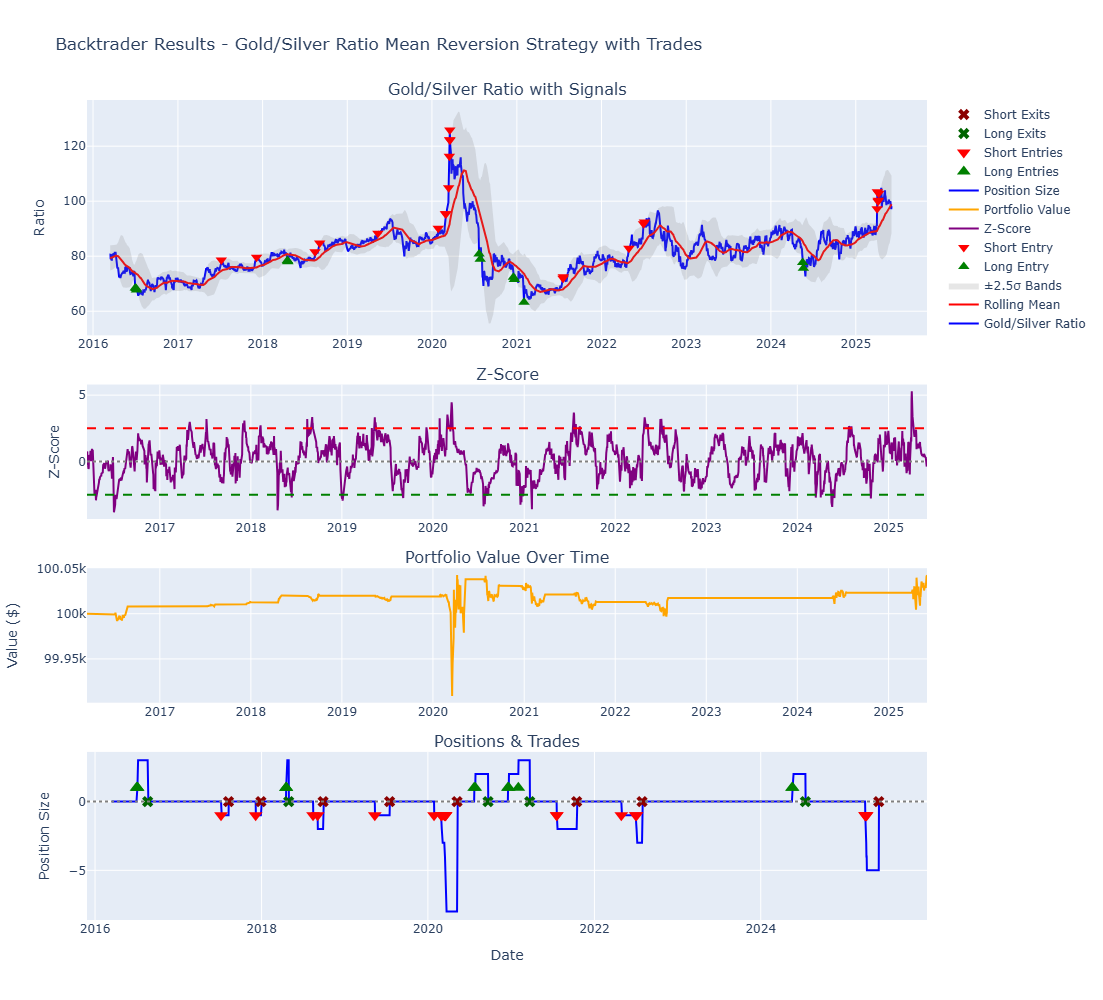


=== TRADE DETAILS ===
Total Trade Entries: 36
Long Entries: 13
Short Entries: 23
Total Trade Exits: 13
Long Exits: 5
Short Exits: 8


In [25]:
# Enhanced Plotly visualization with trades/positions plot
def create_plotly_charts(ratio_df, strategy_result):
    # Create subplots with 4 rows now
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=('Gold/Silver Ratio with Signals', 'Z-Score', 'Portfolio Value Over Time', 'Positions & Trades'),
        vertical_spacing=0.06,
        row_heights=[0.35, 0.2, 0.2, 0.25]
    )
    
    # Plot 1: Ratio with bands and signals
    fig.add_trace(
        go.Scatter(x=ratio_df.index, y=ratio_df['Ratio'], 
                  name='Gold/Silver Ratio', line=dict(color='blue')),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=ratio_df.index, y=ratio_df['rolling_mean'], 
                  name='Rolling Mean', line=dict(color='red')),
        row=1, col=1
    )
    
    # Add bands
    upper_band = ratio_df['rolling_mean'] + 2.5 * ratio_df['rolling_std']
    lower_band = ratio_df['rolling_mean'] - 2.5 * ratio_df['rolling_std']
    
    fig.add_trace(
        go.Scatter(x=ratio_df.index, y=upper_band, 
                  fill=None, mode='lines', line_color='rgba(0,0,0,0)', showlegend=False),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=ratio_df.index, y=lower_band, 
                  fill='tonexty', mode='lines', line_color='rgba(0,0,0,0)', 
                  name='±2.5σ Bands', fillcolor='rgba(128,128,128,0.2)'),
        row=1, col=1
    )
    
    # Add entry signals
    long_entries = ratio_df[ratio_df['long_entry'] == 1]
    short_entries = ratio_df[ratio_df['short_entry'] == 1]
    
    if not long_entries.empty:
        fig.add_trace(
            go.Scatter(x=long_entries.index, y=long_entries['Ratio'],
                      mode='markers', marker=dict(symbol='triangle-up', size=10, color='green'),
                      name='Long Entry'),
            row=1, col=1
        )
    
    if not short_entries.empty:
        fig.add_trace(
            go.Scatter(x=short_entries.index, y=short_entries['Ratio'],
                      mode='markers', marker=dict(symbol='triangle-down', size=10, color='red'),
                      name='Short Entry'),
            row=1, col=1
        )
    
    # Plot 2: Z-Score
    fig.add_trace(
        go.Scatter(x=ratio_df.index, y=ratio_df['rolling_zscore'], 
                  name='Z-Score', line=dict(color='purple')),
        row=2, col=1
    )
    
    # Add horizontal lines at ±2.5
    fig.add_hline(y=2.5, line_dash="dash", line_color="red", row=2, col=1)
    fig.add_hline(y=-2.5, line_dash="dash", line_color="green", row=2, col=1)
    fig.add_hline(y=0, line_dash="dot", line_color="gray", row=2, col=1)
    
    # Plot 3: Portfolio value over time (using tracked values)
    if hasattr(strategy_result, 'portfolio_values') and strategy_result.portfolio_values:
        portfolio_dates = pd.to_datetime(strategy_result.dates)
        fig.add_trace(
            go.Scatter(x=portfolio_dates, y=strategy_result.portfolio_values, 
                      name='Portfolio Value', line=dict(color='orange')),
            row=3, col=1
        )
    else:
        # Fallback to simple start/end if tracking failed
        start_value = 100000
        final_value = cerebro.broker.getvalue()
        dates = [ratio_df.index[0], ratio_df.index[-1]]
        values = [start_value, final_value]
        
        fig.add_trace(
            go.Scatter(x=dates, y=values, 
                      name='Portfolio Value', line=dict(color='orange'), 
                      mode='lines+markers'),
            row=3, col=1
        )
    
    # Plot 4: NEW - Positions and Trades
    if hasattr(strategy_result, 'position_history') and strategy_result.position_history:
        # Convert position history to DataFrame for easier plotting
        pos_df = pd.DataFrame(strategy_result.position_history)
        pos_df['date'] = pd.to_datetime(pos_df['date'])
        
        # Plot position size over time
        fig.add_trace(
            go.Scatter(x=pos_df['date'], y=pos_df['position'], 
                      name='Position Size', line=dict(color='blue', width=2),
                      mode='lines'),
            row=4, col=1
        )
        
        # Add trade entry markers
        if hasattr(strategy_result, 'trade_entries') and strategy_result.trade_entries:
            entries_df = pd.DataFrame(strategy_result.trade_entries)
            entries_df['date'] = pd.to_datetime(entries_df['date'])
            
            # Separate long and short entries
            long_entries_trades = entries_df[entries_df['type'] == 'long_entry']
            short_entries_trades = entries_df[entries_df['type'] == 'short_entry']
            
            if not long_entries_trades.empty:
                fig.add_trace(
                    go.Scatter(x=long_entries_trades['date'], y=long_entries_trades['size'],
                              mode='markers', marker=dict(symbol='triangle-up', size=12, color='green'),
                              name='Long Entries', showlegend=True),
                    row=4, col=1
                )
            
            if not short_entries_trades.empty:
                # For short entries, plot as negative values for visual clarity
                fig.add_trace(
                    go.Scatter(x=short_entries_trades['date'], y=-short_entries_trades['size'],
                              mode='markers', marker=dict(symbol='triangle-down', size=12, color='red'),
                              name='Short Entries', showlegend=True),
                    row=4, col=1
                )
        
        # Add trade exit markers
        if hasattr(strategy_result, 'trade_exits') and strategy_result.trade_exits:
            exits_df = pd.DataFrame(strategy_result.trade_exits)
            exits_df['date'] = pd.to_datetime(exits_df['date'])
            
            # Separate long and short exits
            long_exits_trades = exits_df[exits_df['type'] == 'long_exit']
            short_exits_trades = exits_df[exits_df['type'] == 'short_exit']
            
            if not long_exits_trades.empty:
                fig.add_trace(
                    go.Scatter(x=long_exits_trades['date'], y=[0] * len(long_exits_trades),
                              mode='markers', marker=dict(symbol='x', size=10, color='darkgreen'),
                              name='Long Exits', showlegend=True),
                    row=4, col=1
                )
            
            if not short_exits_trades.empty:
                fig.add_trace(
                    go.Scatter(x=short_exits_trades['date'], y=[0] * len(short_exits_trades),
                              mode='markers', marker=dict(symbol='x', size=10, color='darkred'),
                              name='Short Exits', showlegend=True),
                    row=4, col=1
                )
        
        # Add horizontal line at zero for reference
        fig.add_hline(y=0, line_dash="dot", line_color="gray", row=4, col=1)
    
    # Update layout
    fig.update_layout(
        title='Backtrader Results - Gold/Silver Ratio Mean Reversion Strategy with Trades',
        height=1000,
        showlegend=True
    )
    
    fig.update_xaxes(title_text="Date", row=4, col=1)
    fig.update_yaxes(title_text="Ratio", row=1, col=1)
    fig.update_yaxes(title_text="Z-Score", row=2, col=1)
    fig.update_yaxes(title_text="Value ($)", row=3, col=1)
    fig.update_yaxes(title_text="Position Size", row=4, col=1)
    
    return fig

# Create and show the plots
try:
    fig = create_plotly_charts(ratio, result)
    fig.show()
    
    # Print some additional trade statistics
    if hasattr(result, 'trade_entries') and result.trade_entries:
        print(f"\n=== TRADE DETAILS ===")
        print(f"Total Trade Entries: {len(result.trade_entries)}")
        long_entries = [t for t in result.trade_entries if t['type'] == 'long_entry']
        short_entries = [t for t in result.trade_entries if t['type'] == 'short_entry']
        print(f"Long Entries: {len(long_entries)}")
        print(f"Short Entries: {len(short_entries)}")
        
        if hasattr(result, 'trade_exits') and result.trade_exits:
            print(f"Total Trade Exits: {len(result.trade_exits)}")
            long_exits = [t for t in result.trade_exits if t['type'] == 'long_exit']
            short_exits = [t for t in result.trade_exits if t['type'] == 'short_exit']
            print(f"Long Exits: {len(long_exits)}")
            print(f"Short Exits: {len(short_exits)}")

except Exception as e:
    print(f"Plotting with Plotly failed: {e}")
    print("Results printed above - all performance metrics are available")